In [40]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from quantus.metrics import Complexity
import torch
import io
import glob

# import with torch to cpu
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

path = 'outputs/sleepedf'
# _time_reg_1.0
files = glob.glob(path + '_*_cv_time_reg_1.0.pkl')
attributions = []
for file in files:
    with open(file, 'rb') as f:
        attributions.append(CPU_Unpickler(f).load())


In [41]:
attributions[0]['insertion'].keys()

dict_keys(['filterbank_32_301_0.05', 'filterbank_32_301_0.1', 'filterbank_32_501_0.05', 'filterbank_32_501_0.1', 'filterbank_32_701_0.05', 'filterbank_32_701_0.1', 'filterbank_32_901_0.05', 'filterbank_32_901_0.1', 'filterbank_64_301_0.05', 'filterbank_64_301_0.1', 'filterbank_64_501_0.05', 'filterbank_64_501_0.1', 'filterbank_64_701_0.05', 'filterbank_64_701_0.1', 'filterbank_64_901_0.05', 'filterbank_64_901_0.1', 'filterbank_128_301_0.05', 'filterbank_128_301_0.1', 'filterbank_128_501_0.05', 'filterbank_128_501_0.1', 'filterbank_128_701_0.05', 'filterbank_128_701_0.1', 'filterbank_128_901_0.05', 'filterbank_128_901_0.1', 'filterbank_256_301_0.05', 'filterbank_256_301_0.1', 'filterbank_256_501_0.05', 'filterbank_256_501_0.1', 'filterbank_256_701_0.05', 'filterbank_256_701_0.1', 'filterbank_256_901_0.05', 'filterbank_256_901_0.1'])

In [42]:
accuracies = {}
complexities = {}
for att in attributions:
    for key in att['complexity'].keys():
        if key not in accuracies:
            accuracies[key] = []
            complexities[key] = []
        accuracies[key].append(att['insertion'][key][1][2])
        complexities[key].append(att['complexity'][key])

accs = []
comps = []
num_filters = []
filter_length = []
keep_ratio = []

freq_accs = []
freq_comps = []
freq_keep_ratio = []
for key in accuracies.keys():
    if 'filterbank' in key:
        accs.append(np.mean(accuracies[key]))
        comps.append(np.mean(complexities[key]))
        info = key.split('_')
        num_filters.append(int(info[1]))
        filter_length.append(int(info[2]))
        keep_ratio.append(float(info[3]))
    elif 'freqmask' in key:
        freq_accs.append(np.mean(accuracies[key]))
        freq_comps.append(np.mean(complexities[key]))
        info = key.split('_')
        freq_keep_ratio.append(float(info[1]))

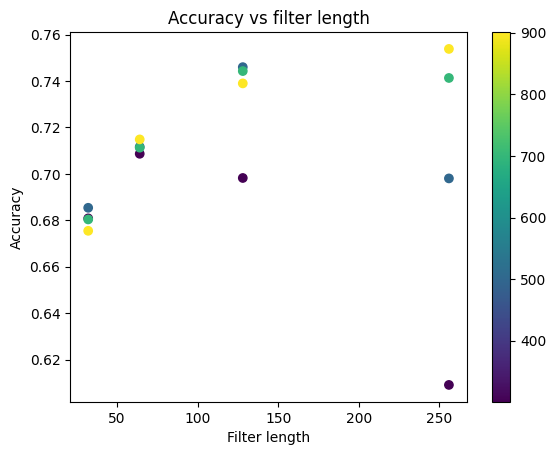

In [43]:
accs_to_plot = np.array(accs)[np.where(np.array(keep_ratio) == 0.1)]
num_filters_to_plot = np.array(num_filters)[np.where(np.array(keep_ratio) == 0.1)]
filter_lengths_to_plot = np.array(filter_length)[np.where(np.array(keep_ratio) == 0.1)]
plt.scatter(num_filters_to_plot, accs_to_plot, c=filter_lengths_to_plot, cmap='viridis')
# color bar
cbar = plt.colorbar()
plt.xlabel('Filter length')
plt.ylabel('Accuracy')
plt.title('Accuracy vs filter length')
plt.show()

In [44]:
# print top 5
top5 = np.argsort(accs)[::-1][:20]
for i in top5:
    print(accs[i], num_filters[i], filter_length[i], keep_ratio[i], comps[i])

0.7538058252334594 256 901 0.1 5.339613497726216
0.7459620857238769 128 501 0.1 5.335193233151208
0.744270438194275 128 701 0.1 5.399639209396605
0.7412953548431396 256 701 0.1 5.4544456363882405
0.7389584465026855 128 901 0.1 5.3570823565585695
0.7148291673660279 64 901 0.1 5.365306012053281
0.7116454153060914 64 501 0.1 5.372536371432119
0.7112697916030883 64 701 0.1 5.382042594832744
0.7086358604431153 64 301 0.1 5.455465082302286
0.7010549612045288 128 501 0.05 5.0115071268404145
0.6982148189544678 128 301 0.1 5.60850696606053
0.6981360158920287 256 901 0.05 4.9947085891188525
0.6980297775268555 256 501 0.1 5.5915436911019025
0.6947149934768677 128 901 0.05 5.044577756047685
0.6926190814971923 128 701 0.05 5.091664599074145
0.6856900033950806 64 301 0.05 5.184471067698449
0.6853775024414063 32 501 0.1 5.453096605581477
0.6808137941360474 32 301 0.1 5.479156656137916
0.6805584259033203 64 901 0.05 5.048872360456754
0.6803623590469361 32 701 0.1 5.3960932428090596


In [45]:
# get all the accuracies equal to the best one and select the one with the lowest complexity
best_acc = np.max(accs)
best_acc_idx = np.where(np.array(accs) == best_acc)[0]
best_complexity = np.inf
best_idx = None
for idx in best_acc_idx:
    if comps[idx] < best_complexity:
        best_complexity = comps[idx]
        best_idx = idx
print('Best accuracy with lowest complexity:', best_acc, num_filters[best_idx], filter_length[best_idx], keep_ratio[best_idx], comps[best_idx])

Best accuracy with lowest complexity: 0.7538058252334594 256 901 0.1 5.339613497726216


In [39]:
freq_accs_top = np.array(freq_accs)[np.where(freq_accs == np.max(freq_accs))[0]]
freq_top_keys = np.array(freq_keep_ratio)[np.where(freq_accs == np.max(freq_accs))[0]]
freq_comps_top = np.array(freq_comps)[np.where(freq_accs == np.max(freq_accs))[0]]
print(freq_accs_top, freq_top_keys, freq_comps_top)



[0.90716333] [0.05] [0.93750967]


In [63]:
# get all the accuracies equal to the best one and select the one with the lowest complexity
best_acc = np.max(freq_accs)
best_acc_idx = np.where(np.array(freq_accs) == best_acc)[0]
best_complexity = np.inf
best_idx = None
for idx in best_acc_idx:
    if freq_comps[idx] < best_complexity:
        best_complexity = freq_comps[idx]
        best_idx = idx
print('Best accuracy with lowest complexity:', best_acc, freq_keep_ratio[best_idx], freq_comps[best_idx])

Best accuracy with lowest complexity: 0.8390673704147339 0.05 0.38817369027809745


In [69]:
# print top 5
top5 = np.argsort(freq_accs)[::-1][:10]
for i in top5:
    print(freq_accs[i], freq_keep_ratio[i], freq_comps[i])

0.8722919425964356 0.05 0.29651584242779555
0.8718978128433228 0.1 0.33986110133547165
